In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import json

class CustomDataset(Dataset):
    def __init__(self, root_dir, annotations_file=None, transform=None):

        self.root_dir = root_dir
        self.transform = transform
        self.annotations = None

        if annotations_file is not None:
            with open(annotations_file, 'r') as file:
                self.annotations = json.load(file)

        self.image_files = list(self.annotations.keys()) if self.annotations else [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        if self.annotations:
            label_name = self.annotations[self.image_files[idx]]
            label = self.label_to_index(label_name)
            return image, label
        else:
            return image

    def label_to_index(self, label_name):

        label_map = {
                        'calling': 0,
                        'clapping': 1,
                        'cycling': 2,
                        'dancing': 3,
                        'drinking': 4,
                        'eating': 5,
                        'fighting': 6,
                        'hugging': 7,
                        'laughing': 8,
                        'listening_to_music': 9,
                        'running': 10,
                        'sitting': 11,
                        'sleeping': 12,
                        'texting': 13,
                        'using_laptop': 14
                    }


        return label_map[label_name]

In [10]:
transform = transforms.Compose([
    transforms.Resize((196,196)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CustomDataset(root_dir='/content/drive/MyDrive/human_activity_retrieval_dataset/train',
                              annotations_file='/content/drive/MyDrive/human_activity_retrieval_dataset/train_image_info.json',
                              transform=transform)

query_dataset = CustomDataset(root_dir='/content/drive/MyDrive/human_activity_retrieval_dataset/query_images',
                              transform=transform)

gallery_dataset = CustomDataset(root_dir='/content/drive/MyDrive/human_activity_retrieval_dataset/gallery',
                                transform=transform)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
query_loader = DataLoader(query_dataset, batch_size=1, shuffle=False)
gallery_loader = DataLoader(gallery_dataset, batch_size=32, shuffle=False)

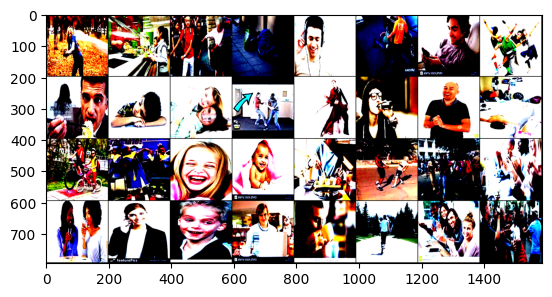

Labels: tensor([ 8,  5,  3, 12,  9,  6,  9,  3,  5, 12,  7,  6,  3,  4,  8, 12,  2,  3,
         8,  8,  5,  6,  6,  1,  4,  0,  8, 14,  4, 10,  1,  6])


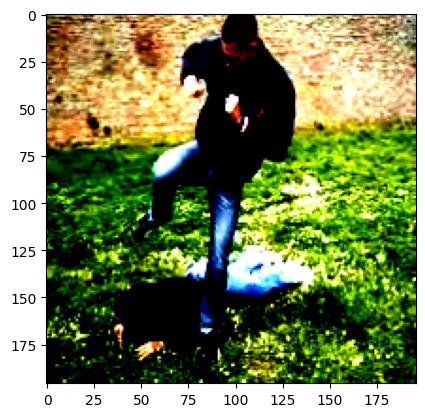

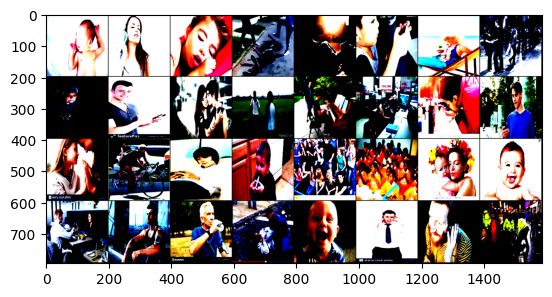

In [12]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np

def imshow(img):
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

def show_dataloader_samples(dataloader, with_labels=False):
    images, labels = next(iter(dataloader)) if with_labels else (next(iter(dataloader)), None)
    imshow(torchvision.utils.make_grid(images))
    if with_labels:
        print('Labels:', labels)

show_dataloader_samples(train_loader, with_labels=True)
show_dataloader_samples(query_loader)
show_dataloader_samples(gallery_loader)

In [13]:
import torch
import torch.nn as nn
from torchvision import models

class EnhancedResNet18(nn.Module):
    def __init__(self, num_classes=15):
        super(EnhancedResNet18, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm1d(256),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.resnet(x)
        x = self.classifier(x)

        return x

model = EnhancedResNet18()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 105MB/s]


In [15]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = EnhancedResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20

Using device: cuda:0


In [16]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_labels = []
    all_preds = []

    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

        if i % 100 == 99:
            print(f'[Epoch: {epoch + 1}, Batch: {i + 1}] Loss: {running_loss / 100:.4f}')
            running_loss = 0.0
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    print(f'End of Epoch {epoch + 1} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

print('Finished Training')

[Epoch: 1, Batch: 100] Loss: 2.5051
[Epoch: 1, Batch: 200] Loss: 2.1766
[Epoch: 1, Batch: 300] Loss: 2.0330
End of Epoch 1 - Accuracy: 0.2873, Precision: 0.2597, Recall: 0.2873, F1 Score: 0.2670
[Epoch: 2, Batch: 100] Loss: 1.8224
[Epoch: 2, Batch: 200] Loss: 1.9749
[Epoch: 2, Batch: 300] Loss: 2.0574
End of Epoch 2 - Accuracy: 0.3719, Precision: 0.3520, Recall: 0.3719, F1 Score: 0.3592
[Epoch: 3, Batch: 100] Loss: 1.8997
[Epoch: 3, Batch: 200] Loss: 1.9552
[Epoch: 3, Batch: 300] Loss: 1.7949
End of Epoch 3 - Accuracy: 0.4004, Precision: 0.3823, Recall: 0.4004, F1 Score: 0.3883
[Epoch: 4, Batch: 100] Loss: 1.5802
[Epoch: 4, Batch: 200] Loss: 1.5921
[Epoch: 4, Batch: 300] Loss: 1.5509
End of Epoch 4 - Accuracy: 0.4927, Precision: 0.4804, Recall: 0.4927, F1 Score: 0.4839
[Epoch: 5, Batch: 100] Loss: 1.3746
[Epoch: 5, Batch: 200] Loss: 1.4091
[Epoch: 5, Batch: 300] Loss: 1.4747
End of Epoch 5 - Accuracy: 0.5434, Precision: 0.5345, Recall: 0.5434, F1 Score: 0.5374
[Epoch: 6, Batch: 100] Lo

In [17]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, models
from PIL import Image

model.eval()  # Set the model to evaluation mode

EnhancedResNet18(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

Similarity: 0.8297613859176636
Image 1:


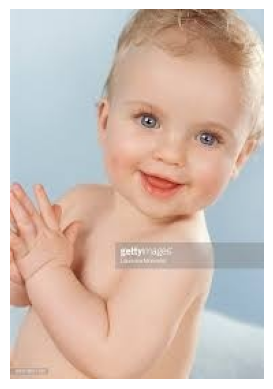

Image 2:


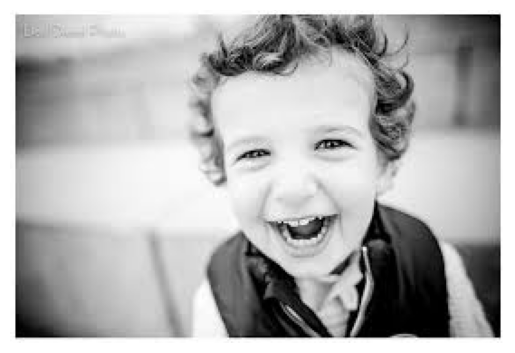

In [18]:
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

def get_features(model, image_tensor):
    image_tensor = image_tensor.to(device)  # Move image tensor to the appropriate device
    with torch.no_grad():
        features = model(image_tensor)
    return features.cpu()  # Move features back to CPU if needed

# Function to compute cosine similarity
def cosine_similarity(tensor1, tensor2):
    return torch.nn.functional.cosine_similarity(tensor1, tensor2).item()

def visualize_image(image_path):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')  # Turn off axis numbers
    plt.show()

# Paths to your images
image_path1 = '/content/drive/MyDrive/human_activity_retrieval_dataset/gallery/Image_12522.jpg'
image_path2 = '/content/drive/MyDrive/human_activity_retrieval_dataset/query_images/Image_12485.jpg'

# Preprocess the images
image_tensor1 = preprocess_image(image_path1)
image_tensor2 = preprocess_image(image_path2)

# Extract features
features1 = get_features(model, image_tensor1)
features2 = get_features(model, image_tensor2)

# Compute similarity
similarity = cosine_similarity(features1, features2)
print(f"Similarity: {similarity}")

# Visualize the images
print("Image 1:")
visualize_image(image_path1)
print("Image 2:")
visualize_image(image_path2)